In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from igraph import Graph, plot
from tqdm import tqdm
from sklearn.metrics import adjusted_rand_score
from scipy.sparse.linalg import eigsh

In [2]:
#importer les graphes générés 
with open('graph_list.pkl', 'rb') as fichier:
    graphs = pickle.load(fichier)

In [3]:
with open('real_partition_list.pkl', 'rb') as f2:
    real_partitions = pickle.load(f2)

In [52]:
fractions=np.linspace(0.0001,0.6,50)
nb_iter=100

In [5]:
def dict_to_list(d):
    L=[0]*len(d)
    for k in d:
        L[k]=d[k]
    return L

In [6]:
def ari_score(communities, real_partition):
    predicted_partition=[0 for i in range(len(real_partition))]
    for k in range(len(communities)):
        for i in communities[k]:
            predicted_partition[i]=k
    score = adjusted_rand_score(real_partition, predicted_partition)
    return score

## Louvain


In [7]:
from community import community_louvain

In [8]:
ARI_louvain = []
for i in tqdm(range(len(fractions))):
    L=np.zeros(nb_iter)
    for j in range(nb_iter):
        G=nx.from_numpy_array(graphs[i][j])
        partition =dict_to_list(community_louvain.best_partition(G))
        L[j]=adjusted_rand_score(partition,real_partitions[i][j])
    ARI_louvain.append(L.mean())
    

100%|██████████| 30/30 [01:11<00:00,  2.38s/it]


In [9]:
with open('ARI_louvain.pkl', 'wb') as fichier:
    pickle.dump(ARI_louvain, fichier)

## Walktrap

In [12]:
ARI_walktrap = []
for i in tqdm(range(len(fractions))):
    L=np.zeros(nb_iter)
    for j in range(nb_iter):
        G=Graph.Adjacency(graphs[i][j],mode='undirected')
        community = G.community_walktrap(weights=None,steps = 7)
        clusters = community.as_clustering()
        partition=clusters.membership
        L[j]=adjusted_rand_score(partition,real_partitions[i][j])
    ARI_walktrap.append(L.mean())

100%|██████████| 30/30 [03:07<00:00,  6.24s/it]


In [13]:
with open('ARI_walktrap.pkl', 'wb') as fichier:
    pickle.dump(ARI_walktrap, fichier)

## Factorisation matricielle

In [15]:
def fit_model(A,K=65,total_steps=50, lambda_=0, fix_X=None):
    n = len(A)
    if fix_X is None:
        X=np.random.rand(n, K)
    else:
        X=fix_X
    if lambda_>0:
        n=A.shape[0]
        D=np.zeros((n,n), dtype='float')
        for i in range(n):
            for j in range(n):
                D[i,i]=D[i,i]+A[i,j]
    for step in range(total_steps):
        U_=np.dot(A,X)
        M=np.dot(X.T,X)
        M=np.dot(X,M)
        M[M==0]=1e-15
        #regularization
        if lambda_>0:
            U_=(1+lambda_)*U_
            C=np.dot(D,X)
            C=lambda_*C
            M=M+C
        for i in range(n):
            for k in range(K):
                # print(f'i:{i}, k:{k}, M[i,k]: {M[i,k]}')
                X[i,k]=X[i,k]*(0.5+0.5*U_[i,k]/M[i,k])
        # if step%10==0:
        #     print(f'step: {step}, RMSE: {np.sqrt(np.mean((A-np.dot(X,X.T))**2))}')
    return X

In [16]:
def community_detection(X):
    communities={}
    n,col=X.shape
    for k in range(col):
        communities[k]=[]
    for i in range(n):
        communities[np.argmax(X[i,:])].append(i)
    permutation_list=[]
    for value in communities.values():
        permutation_list +=value
    permutation_=np.array(permutation_list)
    return communities, permutation_

In [17]:
ARI_fact_non_reg = []
for i in tqdm(range(len(fractions))):
    L=np.zeros(nb_iter)
    for j in range(nb_iter):
        G=Graph.Adjacency(graphs[i][j],mode='undirected')
        X = fit_model(graphs[i][j],K=5,total_steps=50, lambda_=0)
        communities, permutation_ = community_detection(X)
        L[j]=ari_score(communities, real_partitions[i][j])
    ARI_fact_non_reg.append(L.mean())

100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


In [18]:
with open('ARI_fact_non_reg.pkl', 'wb') as fichier:
    pickle.dump(ARI_fact_non_reg, fichier)

In [45]:
ARI_fact_reg = []
for i in tqdm(range(len(fractions))):
    L=np.zeros(nb_iter)
    for j in range(nb_iter):
        G=Graph.Adjacency(graphs[i][j],mode='undirected')
        X = fit_model(graphs[i][j],K=5,total_steps=50, lambda_=0.1)
        communities, permutation_ = community_detection(X)
        L[j]=ari_score(communities, real_partitions[i][j])
    ARI_fact_reg.append(L.mean())

100%|██████████| 30/30 [01:24<00:00,  2.80s/it]


In [46]:
with open('ARI_fact_reg.pkl', 'wb') as fichier:
    pickle.dump(ARI_fact_reg, fichier)

Récupérer et tracer

In [50]:
with open('ARI_louvain.pkl', 'rb') as fichier:
    ARI_louvain = pickle.load(fichier)
    
with open('ARI_walktrap.pkl', 'rb') as fichier:
    ARI_walktrap = pickle.load(fichier)

with open('ARI_fact_non_reg.pkl', 'rb') as fichier:
    ARI_fact_non_reg = pickle.load(fichier)

# with open('ARI_fact_reg.pkl', 'rb') as fichier:
#     ARI_fact_reg = pickle.load(fichier)


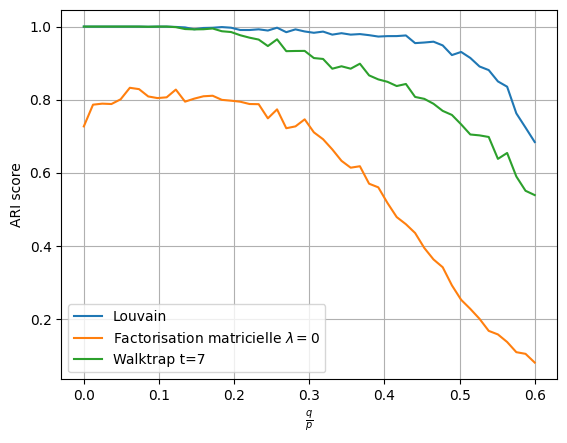

In [54]:
plt.plot(fractions , ARI_louvain , label='Louvain')
plt.plot(fractions , ARI_fact_non_reg , label=r'Factorisation matricielle $\lambda=0$')
#plt.plot(fractions , ARI_fact_reg , label=r'Factorisation matricielle $\lambda=1$')
plt.plot(fractions , ARI_walktrap , label='Walktrap t=7')
plt.grid(True)
plt.ylabel('ARI score')
plt.xlabel(r'$\frac{q}{p}$')
plt.legend(loc='best')
plt.show()